# Progetto Bianchetti-Terraneo — Gruppo 7
## Swaption Pricing nel Modello di Vasicek

### Consegna

Prezzare una **payer** e una **receiver swaption** nel modello di Vasicek:

| Parametro | Valore |
|-----------|--------|
| $r(0)$ | 1.5% |
| $k$ (mean reversion) | 0.5 |
| $\theta$ (long-term mean) | 2% |
| $\sigma$ (volatilità) | 0.15 |
| Fixing date | 10Y |
| Tenor | 5Y |
| Strike | 1.3% |

**Metodo:** Monte Carlo (obbligatorio) + Formula analitica (opzionale).

**Scelta della misura:** Implementiamo entrambe le misure (risk-neutral $\mathbb{Q}$ e $T$-forward) e confrontiamo i risultati con il benchmark analitico di Jamshidian.

---
## 1. Modello di Vasicek — Teoria

### 1.1 Dinamica del tasso short

Sotto la misura risk-neutral $\mathbb{Q}$, il tasso short $r(t)$ segue il processo di Ornstein-Uhlenbeck:

$$dr(t) = k(\theta - r(t))\,dt + \sigma\,dW^{\mathbb{Q}}(t)$$

Il processo è **mean-reverting**: $r(t)$ tende verso $\theta$ con velocità $k$.

### 1.2 Distribuzione esatta

$r(T)$ condizionato a $r(t)$ è gaussiano:

$$r(T) \mid r(t) \sim \mathcal{N}\Big(\mu_{\mathbb{Q}},\; v^2\Big)$$

con:
$$\mu_{\mathbb{Q}} = r(t)e^{-k(T-t)} + \theta(1-e^{-k(T-t)}), \qquad v^2 = \frac{\sigma^2}{2k}(1-e^{-2k(T-t)})$$

### 1.3 Prezzo Zero-Coupon Bond

$$P(t, T) = A(\tau)\,e^{-B(\tau)\,r(t)}$$

con $\tau = T - t$ e:
$$B(\tau) = \frac{1-e^{-k\tau}}{k}, \qquad A(\tau) = \exp\Big[\Big(\theta - \frac{\sigma^2}{2k^2}\Big)(B(\tau)-\tau) - \frac{\sigma^2}{4k}B(\tau)^2\Big]$$

**Nota:** $P(t,T)$ dipende solo da $\tau = T-t$ e $r(t)$.

### 1.4 Swaption: definizione del payoff

Uno swap payer paga il tasso fisso $K$ e riceve il tasso variabile. Il tasso swap forward a $T_{fix}$, per un tenor di $n$ anni con pagamenti fissi annuali, è:

$$S(T_{fix}) = \frac{1 - P(T_{fix},\, T_{fix}+n)}{\sum_{i=1}^{n} P(T_{fix},\, T_{fix}+i)}$$

dove il numeratore è la gamba variabile (per telescoping dei forward) e il denominatore è l'**annuity** (DV01).

I payoff a $T_{fix}$ sono:
- **Payer swaption:** $\;\max(S - K,\; 0) \times A$
- **Receiver swaption:** $\;\max(K - S,\; 0) \times A$

dove $A = \sum_{i=1}^{n} P(T_{fix},\, T_{fix}+i)$ è l'annuity.

### 1.5 Scelta della misura: un punto cruciale

Per portare il payoff al tempo 0 servono due approcci **equivalenti ma non intercambiabili**:

#### Approccio 1 — Misura risk-neutral $\mathbb{Q}$ (multi-step)

$$V(0) = \mathbb{E}^{\mathbb{Q}}\Big[e^{-\int_0^{T_{fix}} r(s)\,ds} \cdot \text{Payoff}(r(T_{fix}))\Big]$$

Qui il fattore di sconto $D(0,T) = e^{-\int_0^T r(s)ds}$ è **stocastico** e **correlato** con $r(T_{fix})$. Serve simulare l'intero path di $r$ per accumulare l'integrale.

#### Approccio 2 — Misura $T_{fix}$-forward (single-step)

$$V(0) = P(0, T_{fix}) \cdot \mathbb{E}^{\mathbb{Q}^{T_{fix}}}\Big[\text{Payoff}(r(T_{fix}))\Big]$$

Sotto $\mathbb{Q}^{T_{fix}}$, lo sconto è **deterministico** ($P(0,T_{fix})$), ma la dinamica di $r$ cambia:

$$dr(t) = \Big[k(\theta - r(t)) - \sigma^2 B(T_{fix}-t)\Big]\,dt + \sigma\,dW^{T_{fix}}(t)$$

La distribuzione di $r(T_{fix})$ sotto $\mathbb{Q}^{T_{fix}}$ è ancora gaussiana ma con **media diversa**:

$$\mu_{\mathbb{Q}^T} = \mu_{\mathbb{Q}} - \sigma^2 \int_0^T e^{-k\tau} B(\tau)\,d\tau$$

**Errore comune:** usare la distribuzione di $\mathbb{Q}$ con lo sconto deterministico $P(0,T)$ mescola le due misure e produce prezzi sbagliati.

---
## 2. Setup e funzioni del modello

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12
np.random.seed(42)

In [2]:
# ============================================================
# PARAMETRI DEL MODELLO E DELLA SWAPTION
# ============================================================
r0    = 0.015    # tasso short iniziale
k     = 0.5      # velocità di mean reversion
theta = 0.02     # livello di lungo periodo
sigma = 0.15     # volatilità del tasso short

T_fix  = 10.0    # fixing date (expiry della swaption)
tenor  = 5.0     # tenor dello swap sottostante
n_fix  = 5       # numero pagamenti fissi (annuali)
strike = 0.013   # 1.3%

# Date di pagamento dello swap (dal fixing)
fix_tenors = np.arange(1.0, tenor + 1.0)  # [1, 2, 3, 4, 5]

print(f"Modello Vasicek: r0={r0}, k={k}, theta={theta}, sigma={sigma}")
print(f"Swaption: fixing={T_fix}Y, tenor={tenor}Y, strike={strike*100}%")
print(f"Date pagamento fisso: {fix_tenors}")

Modello Vasicek: r0=0.015, k=0.5, theta=0.02, sigma=0.15
Swaption: fixing=10.0Y, tenor=5.0Y, strike=1.3%
Date pagamento fisso: [1. 2. 3. 4. 5.]


In [3]:
# ============================================================
# FUNZIONI VASICEK
# ============================================================

def B_vas(tau):
    """Funzione B(tau) del modello Vasicek."""
    return (1.0 - np.exp(-k * tau)) / k

def A_vas(tau):
    """Funzione A(tau) del modello Vasicek."""
    B = B_vas(tau)
    return np.exp((theta - sigma**2 / (2*k**2)) * (B - tau) - sigma**2 / (4*k) * B**2)

def P_vas(tau, rt):
    """Prezzo ZCB: P(t,T) = A(tau)*exp(-B(tau)*r(t)), con tau = T-t.
    Dipende solo da tau e dal tasso corrente."""
    return A_vas(tau) * np.exp(-B_vas(tau) * rt)

def swap_rate(rt):
    """Tasso swap forward S(r) = (1 - P(T,T+n)) / Annuity."""
    P_end = P_vas(tenor, rt)
    annuity = np.sum(np.column_stack([P_vas(tau, rt) for tau in fix_tenors]), axis=1) \
              if np.ndim(rt) > 0 else sum(P_vas(tau, rt) for tau in fix_tenors)
    return (1.0 - P_end) / annuity, annuity

# ---------- Verifica: curva zero-coupon a t=0 ----------
maturities = np.arange(1, 21)
zcb_prices = np.array([P_vas(T, r0) for T in maturities])
zero_rates = -np.log(zcb_prices) / maturities

print("Curva Zero Rates Vasicek (t=0):")
for T, zr, p in zip(maturities, zero_rates, zcb_prices):
    if T <= 5 or T % 5 == 0:
        print(f"  {T:2.0f}Y: rate = {zr*100:+.4f}%,  P(0,{T}) = {p:.6f}")

# Nota: con sigma=0.15, P(0,T)>1 per T grandi → tassi negativi
# Questo è un limite noto del modello Vasicek
P_0_Tfix = P_vas(T_fix, r0)
print(f"\nP(0, {T_fix:.0f}Y) = {P_0_Tfix:.6f}  {'(>1: tassi negativi medi!)' if P_0_Tfix > 1 else ''}")

Curva Zero Rates Vasicek (t=0):
   1Y: rate = +1.3444%,  P(0,1) = 0.986646
   2Y: rate = +0.9275%,  P(0,2) = 0.981620
   3Y: rate = +0.4769%,  P(0,3) = 0.985794
   4Y: rate = +0.0704%,  P(0,4) = 0.997187
   5Y: rate = -0.2730%,  P(0,5) = 1.013745
  10Y: rate = -1.2614%,  P(0,10) = 1.134445
  15Y: rate = -1.6673%,  P(0,15) = 1.284146
  20Y: rate = -1.8750%,  P(0,20) = 1.455003

P(0, 10Y) = 1.134445  (>1: tassi negativi medi!)


---
## 3. Monte Carlo — Misura Risk-Neutral $\mathbb{Q}$ (multi-step)

Simuliamo il path completo di $r(t)$ da $0$ a $T_{fix}$ usando la **distribuzione esatta** del processo OU (non Euler-Maruyama, per evitare bias di discretizzazione).

Per ogni step da $t$ a $t+\Delta t$:
$$r(t+\Delta t) = r(t) e^{-k\Delta t} + \theta(1-e^{-k\Delta t}) + \sigma\sqrt{\frac{1-e^{-2k\Delta t}}{2k}}\;Z$$

Accumuliamo $\int_0^{T_{fix}} r(s)\,ds$ con la regola dei trapezi per ottenere il fattore di sconto stocastico.

In [4]:
# ============================================================
# MC RISK-NEUTRAL: SIMULAZIONE ESATTA + SCONTO STOCASTICO
# ============================================================
N_sim   = 200_000   # numero simulazioni
N_steps = 120       # passi temporali (mensile ~ 10Y/120 = 1 mese)
dt = T_fix / N_steps

# Coefficienti per la simulazione esatta di OU
exp_kdt  = np.exp(-k * dt)
mean_coeff = theta * (1 - exp_kdt)     # parte deterministica del drift
std_dt = sigma * np.sqrt((1 - np.exp(-2*k*dt)) / (2*k))  # deviazione standard condizionale

print(f"Simulazione: {N_sim:,} paths × {N_steps} steps (dt = {dt:.4f}Y ≈ {dt*12:.1f} mesi)")
print(f"Metodo: distribuzione esatta OU (nessun bias di discretizzazione)")

# Simulazione path-by-path
np.random.seed(42)
r_curr = np.full(N_sim, r0)
disc_integral = np.zeros(N_sim)  # accumula ∫r(s)ds

for step in range(N_steps):
    r_prev = r_curr.copy()
    Z = np.random.randn(N_sim)
    # Transizione esatta: r(t+dt) | r(t) ~ N(r(t)*e^{-k dt} + theta*(1-e^{-k dt}), std_dt^2)
    r_curr = r_prev * exp_kdt + mean_coeff + std_dt * Z
    # Regola dei trapezi per l'integrale
    disc_integral += 0.5 * (r_prev + r_curr) * dt

# Fattore di sconto stocastico D(0, T_fix) = exp(-∫₀ᵀ r(s) ds)
stoch_df = np.exp(-disc_integral)
r_T_Q = r_curr  # r(T_fix) sotto Q

print(f"\nStatistiche r(T_fix) sotto Q:")
print(f"  Media MC:  {np.mean(r_T_Q):.6f} (teorica: {r0*np.exp(-k*T_fix) + theta*(1-np.exp(-k*T_fix)):.6f})")
print(f"  Std MC:    {np.std(r_T_Q):.6f} (teorica: {sigma*np.sqrt((1-np.exp(-2*k*T_fix))/(2*k)):.6f})")
print(f"  Media D(0,T): {np.mean(stoch_df):.6f} (teorica P(0,T): {P_0_Tfix:.6f})")

Simulazione: 200,000 paths × 120 steps (dt = 0.0833Y ≈ 1.0 mesi)
Metodo: distribuzione esatta OU (nessun bias di discretizzazione)



Statistiche r(T_fix) sotto Q:
  Media MC:  0.019911 (teorica: 0.019966)
  Std MC:    0.150052 (teorica: 0.149997)
  Media D(0,T): 1.135127 (teorica P(0,T): 1.134445)


In [5]:
# Calcolo swap rate e payoff per ogni scenario
S_Q, A_Q = swap_rate(r_T_Q)

payer_payoff_Q   = np.maximum(S_Q - strike, 0) * A_Q
receiver_payoff_Q = np.maximum(strike - S_Q, 0) * A_Q

# Prezzo = E^Q[D(0,T) × Payoff]  (sconto stocastico!)
payer_Q   = np.mean(payer_payoff_Q * stoch_df)
receiver_Q = np.mean(receiver_payoff_Q * stoch_df)

# Standard error
payer_se_Q   = np.std(payer_payoff_Q * stoch_df) / np.sqrt(N_sim)
receiver_se_Q = np.std(receiver_payoff_Q * stoch_df) / np.sqrt(N_sim)

print("=" * 55)
print("  MC RISK-NEUTRAL (Q) — sconto stocastico")
print("=" * 55)
print(f"  Payer Swaption:    {payer_Q:.6f}  ({payer_Q*10000:.2f} bps)  ± {1.96*payer_se_Q*10000:.2f} bps")
print(f"  Receiver Swaption: {receiver_Q:.6f}  ({receiver_Q*10000:.2f} bps)  ± {1.96*receiver_se_Q*10000:.2f} bps")
print(f"  Swap rate medio:   {np.mean(S_Q)*100:.4f}%")
print("=" * 55)

  MC RISK-NEUTRAL (Q) — sconto stocastico
  Payer Swaption:    0.049685  (496.85 bps)  ± 4.63 bps
  Receiver Swaption: 0.280118  (2801.18 bps)  ± 29.70 bps
  Swap rate medio:   0.3434%


---
## 4. Monte Carlo — Misura $T_{fix}$-Forward (single-step)

Sotto la misura $\mathbb{Q}^{T_{fix}}$ (numeraire $P(t, T_{fix})$), lo sconto diventa deterministico:

$$V(0) = P(0, T_{fix}) \cdot \mathbb{E}^{\mathbb{Q}^T}[\text{Payoff}(r(T_{fix}))]$$

La distribuzione di $r(T_{fix})$ sotto $\mathbb{Q}^T$ è:

$$r(T_{fix}) \sim \mathcal{N}(\mu_{\mathbb{Q}^T},\; v^2)$$

dove la varianza $v^2$ è la stessa di $\mathbb{Q}$, ma la media cambia:

$$\mu_{\mathbb{Q}^T} = \mu_{\mathbb{Q}} - \sigma^2 \underbrace{\int_0^T e^{-k\tau} B(\tau)\,d\tau}_{= \frac{B(T)}{k} - \frac{1-e^{-2kT}}{2k^2}}$$

L'aggiustamento è **negativo** perché la misura forward "pesa di più" gli scenari a tassi bassi (dove il fattore di sconto è più alto).

In [6]:
# ============================================================
# MC T-FORWARD MEASURE: SINGLE-STEP + SCONTO DETERMINISTICO
# ============================================================

# Media sotto Q
mu_Q = r0 * np.exp(-k * T_fix) + theta * (1 - np.exp(-k * T_fix))
v = sigma * np.sqrt((1 - np.exp(-2*k*T_fix)) / (2*k))

# Calcolo dell'aggiustamento di misura (integrale analitico)
# ∫₀ᵀ e^{-kτ} B(τ) dτ = B(T)/k - (1 - e^{-2kT})/(2k²)
measure_integral = B_vas(T_fix)/k - (1 - np.exp(-2*k*T_fix))/(2*k**2)

# Media sotto Q^T: la misura forward "tira giù" la media
mu_QT = mu_Q - sigma**2 * measure_integral

print(f"Media r(T_fix) sotto Q:    {mu_Q:.6f}  ({mu_Q*100:.3f}%)")
print(f"Media r(T_fix) sotto Q^T:  {mu_QT:.6f}  ({mu_QT*100:.3f}%)")
print(f"Aggiustamento di misura:   {-sigma**2 * measure_integral:.6f}")
print(f"Std (uguale in entrambe):  {v:.6f}")
print(f"\n→ Sotto Q^T la media è più bassa: la misura forward")
print(f"  sovrappesa gli scenari a tassi bassi (D grande).")

Media r(T_fix) sotto Q:    0.019966  (1.997%)
Media r(T_fix) sotto Q^T:  -0.024429  (-2.443%)
Aggiustamento di misura:   -0.044396
Std (uguale in entrambe):  0.149997

→ Sotto Q^T la media è più bassa: la misura forward
  sovrappesa gli scenari a tassi bassi (D grande).


In [7]:
# Simulazione single-step sotto Q^T
np.random.seed(42)
r_T_fwd = mu_QT + v * np.random.randn(N_sim)

# Swap rate e annuity (stessa formula, distribuzione diversa di r)
S_fwd, A_fwd = swap_rate(r_T_fwd)

payer_payoff_fwd   = np.maximum(S_fwd - strike, 0) * A_fwd
receiver_payoff_fwd = np.maximum(strike - S_fwd, 0) * A_fwd

# Prezzo = P(0, T_fix) × E^{Q^T}[Payoff]  (sconto deterministico)
payer_fwd   = P_0_Tfix * np.mean(payer_payoff_fwd)
receiver_fwd = P_0_Tfix * np.mean(receiver_payoff_fwd)

payer_se_fwd   = P_0_Tfix * np.std(payer_payoff_fwd) / np.sqrt(N_sim)
receiver_se_fwd = P_0_Tfix * np.std(receiver_payoff_fwd) / np.sqrt(N_sim)

print("=" * 55)
print("  MC T-FORWARD MEASURE — sconto deterministico")
print("=" * 55)
print(f"  P(0, T_fix) = {P_0_Tfix:.6f}")
print(f"  Payer Swaption:    {payer_fwd:.6f}  ({payer_fwd*10000:.2f} bps)  ± {1.96*payer_se_fwd*10000:.2f} bps")
print(f"  Receiver Swaption: {receiver_fwd:.6f}  ({receiver_fwd*10000:.2f} bps)  ± {1.96*receiver_se_fwd*10000:.2f} bps")
print(f"  Swap rate medio:   {np.mean(S_fwd)*100:.4f}%")
print("=" * 55)

  MC T-FORWARD MEASURE — sconto deterministico
  P(0, T_fix) = 1.134445
  Payer Swaption:    0.050069  (500.69 bps)  ± 4.50 bps
  Receiver Swaption: 0.278880  (2788.80 bps)  ± 14.16 bps
  Swap rate medio:   -1.2896%


---
## 5. Formula Analitica — Decomposizione di Jamshidian

Nel modello di Vasicek esiste una formula chiusa per le opzioni su ZCB. Tramite la decomposizione di **Jamshidian (1989)** la swaption si scompone in un portafoglio di opzioni su ZCB.

### Idea

Il payoff della **payer swaption** a $T_{fix}$ è:

$$\max\Big(1 - \sum_{i=1}^n c_i\, P(T_{fix}, T_i),\; 0\Big)$$

con $c_i = K$ per $i < n$ e $c_n = 1 + K$ (coupon + notional). Poiché $P(T_{fix}, T_i)$ è **monotona decrescente** in $r(T_{fix})$, esiste un $r^*$ critico tale che il payoff è zero:

$$\sum_{i=1}^n c_i\, P(T_{fix}, T_i;\, r^*) = 1$$

Definendo $K_i = P(T_{fix}, T_i;\, r^*)$:

$$\text{Payer} = \sum_{i=1}^n c_i \cdot \text{Put}_{ZCB}(0, T_{fix}, T_i, K_i)$$
$$\text{Receiver} = \sum_{i=1}^n c_i \cdot \text{Call}_{ZCB}(0, T_{fix}, T_i, K_i)$$

### Formula ZCB option (Vasicek)

$$\text{Call} = P(0, T_B)\,\Phi(h) - K_i\,P(0, T_{fix})\,\Phi(h - \sigma_P)$$

con:
$$\sigma_P = \frac{\sigma}{k}(1-e^{-k(T_B - T_{fix})})\sqrt{\frac{1-e^{-2k T_{fix}}}{2k}}, \qquad h = \frac{1}{\sigma_P}\ln\frac{P(0,T_B)}{K_i\,P(0,T_{fix})} + \frac{\sigma_P}{2}$$

In [8]:
# ============================================================
# FORMULA ANALITICA DI JAMSHIDIAN
# ============================================================

def zcb_option_vasicek(T_opt, T_bond, K_bond, rt, option_type='call'):
    """Prezzo di un'opzione europea su ZCB nel modello Vasicek.
    
    Args:
        T_opt:   scadenza dell'opzione
        T_bond:  maturity dello ZCB sottostante
        K_bond:  strike dell'opzione
        rt:      tasso short corrente r(0)
        option_type: 'call' o 'put'
    """
    # Volatilità del prezzo del bond alla scadenza dell'opzione
    sigma_P = (sigma / k) * (1 - np.exp(-k * (T_bond - T_opt))) * \
              np.sqrt((1 - np.exp(-2 * k * T_opt)) / (2 * k))
    
    P_bond = P_vas(T_bond, rt)     # P(0, T_bond)
    P_opt  = P_vas(T_opt, rt)      # P(0, T_opt)
    
    h = (1 / sigma_P) * np.log(P_bond / (K_bond * P_opt)) + sigma_P / 2
    
    if option_type == 'call':
        return P_bond * norm.cdf(h) - K_bond * P_opt * norm.cdf(h - sigma_P)
    else:  # put
        return K_bond * P_opt * norm.cdf(-h + sigma_P) - P_bond * norm.cdf(-h)


# 1. Trovare r* tale che sum(c_i * P(T_fix, T_i; r*)) = 1
def coupon_bond_from_r(r_val):
    """Valore del bond con cedola = strike, al variare di r(T_fix)."""
    total = 0.0
    for i, tau in enumerate(fix_tenors):
        c = strike + (1.0 if i == n_fix - 1 else 0.0)
        total += c * P_vas(tau, r_val)
    return total

r_star = brentq(lambda r: coupon_bond_from_r(r) - 1.0, -2, 2)
print(f"r* (tasso critico di Jamshidian): {r_star:.6f} ({r_star*100:.3f}%)")

# 2. Strike individuali: K_i = P(T_fix, T_fix+i; r*)
K_strikes = np.array([P_vas(tau, r_star) for tau in fix_tenors])
print(f"\nStrike ZCB (K_i = P(T_fix, T_i; r*)):")
for i, (tau, Ki) in enumerate(zip(fix_tenors, K_strikes)):
    c = strike + (1.0 if i == n_fix - 1 else 0.0)
    print(f"  i={i+1}: T_i={T_fix+tau:.0f}Y, K_i={Ki:.6f}, c_i={c:.4f}")

# 3. Somma delle opzioni ZCB
payer_J = 0.0
receiver_J = 0.0
for i, tau in enumerate(fix_tenors):
    c = strike + (1.0 if i == n_fix - 1 else 0.0)
    T_bond = T_fix + tau
    payer_J   += c * zcb_option_vasicek(T_fix, T_bond, K_strikes[i], r0, 'put')
    receiver_J += c * zcb_option_vasicek(T_fix, T_bond, K_strikes[i], r0, 'call')

print(f"\n{'='*55}")
print(f"  JAMSHIDIAN ANALYTICAL")
print(f"{'='*55}")
print(f"  Payer Swaption:    {payer_J:.6f}  ({payer_J*10000:.2f} bps)")
print(f"  Receiver Swaption: {receiver_J:.6f}  ({receiver_J*10000:.2f} bps)")
print(f"{'='*55}")

r* (tasso critico di Jamshidian): 0.056608 (5.661%)

Strike ZCB (K_i = P(T_fix, T_i; r*)):
  i=1: T_i=11Y, K_i=0.954863, c_i=0.0130
  i=2: T_i=12Y, K_i=0.931320, c_i=0.0130
  i=3: T_i=13Y, K_i=0.924081, c_i=0.0130
  i=4: T_i=14Y, K_i=0.927956, c_i=0.0130
  i=5: T_i=15Y, K_i=0.939194, c_i=1.0130

  JAMSHIDIAN ANALYTICAL
  Payer Swaption:    0.049964  (499.64 bps)
  Receiver Swaption: 0.279131  (2791.31 bps)


---
## 6. Confronto dei risultati

In [9]:
# ============================================================
# TABELLA COMPARATIVA
# ============================================================
print(f"{'Metodo':<40} {'Payer (bps)':>12} {'Receiver (bps)':>15}")
print("-" * 70)
print(f"{'Jamshidian (analitico, benchmark)':<40} {payer_J*10000:>12.2f} {receiver_J*10000:>15.2f}")
print(f"{'MC Risk-Neutral Q (multi-step)':<40} {payer_Q*10000:>12.2f} {receiver_Q*10000:>15.2f}")
print(f"{'MC T-forward (single-step)':<40} {payer_fwd*10000:>12.2f} {receiver_fwd*10000:>15.2f}")
print("-" * 70)

print(f"\nDifferenze rispetto a Jamshidian:")
print(f"  MC Q:       Payer {(payer_Q-payer_J)*10000:+.2f} bps,  Receiver {(receiver_Q-receiver_J)*10000:+.2f} bps")
print(f"  MC T-fwd:   Payer {(payer_fwd-payer_J)*10000:+.2f} bps,  Receiver {(receiver_fwd-receiver_J)*10000:+.2f} bps")
print(f"\n→ Entrambi i metodi MC convergono al benchmark analitico.")
print(f"  Le differenze sono nell'ordine dell'errore standard MC.")

Metodo                                    Payer (bps)  Receiver (bps)
----------------------------------------------------------------------
Jamshidian (analitico, benchmark)              499.64         2791.31
MC Risk-Neutral Q (multi-step)                 496.85         2801.18
MC T-forward (single-step)                     500.69         2788.80
----------------------------------------------------------------------

Differenze rispetto a Jamshidian:
  MC Q:       Payer -2.79 bps,  Receiver +9.86 bps
  MC T-fwd:   Payer +1.05 bps,  Receiver -2.51 bps

→ Entrambi i metodi MC convergono al benchmark analitico.
  Le differenze sono nell'ordine dell'errore standard MC.


---
## 7. Verifica: Put-Call Parity

La relazione di parità per le swaption è:

$$\text{Payer} - \text{Receiver} = V_{\text{swap forward}}$$

dove $V_{\text{swap forward}} = P(0,T_{fix}) \cdot \mathbb{E}^{T}[(S - K) \cdot A] = \big(1 - P(0, T_{end})\big) - K \cdot \sum_i P(0, T_i)$ calcolato dalla curva iniziale.

In [10]:
# Valore forward dello swap dalla curva a t=0
float_leg_0 = 1.0 - P_vas(T_fix + tenor, r0)  # P(0, 0) - P(0, 15)
# Attenzione: qui calcoliamo P(0, T_fix+i) non P(T_fix, T_fix+i)
fixed_leg_0 = strike * sum(P_vas(T_fix + tau, r0) for tau in fix_tenors)
swap_fwd_value = float_leg_0 - fixed_leg_0 - P_vas(T_fix, r0) + 1  # corretto per il notional

# Put-call parity per i tre metodi
for name, p, r in [("Jamshidian", payer_J, receiver_J),
                    ("MC Q", payer_Q, receiver_Q),
                    ("MC T-fwd", payer_fwd, receiver_fwd)]:
    diff = p - r
    print(f"{name:<15}: Payer - Receiver = {diff*10000:+.2f} bps")

# Verifica interna MC: confronto diretto con il valore dello swap
print(f"\nVerifica interna MC Q:")
swap_mc = np.mean((S_Q - strike) * A_Q * stoch_df)
print(f"  E^Q[D × (S-K) × A] = {swap_mc*10000:+.2f} bps")
print(f"  Payer - Receiver    = {(payer_Q - receiver_Q)*10000:+.2f} bps")
print(f"  Differenza: {abs(swap_mc - (payer_Q - receiver_Q))*10000:.2e} bps → {'OK' if abs(swap_mc - (payer_Q - receiver_Q)) < 1e-6 else 'check'}")

Jamshidian     : Payer - Receiver = -2291.67 bps
MC Q           : Payer - Receiver = -2304.33 bps
MC T-fwd       : Payer - Receiver = -2288.11 bps

Verifica interna MC Q:
  E^Q[D × (S-K) × A] = -2304.33 bps
  Payer - Receiver    = -2304.33 bps
  Differenza: 2.78e-13 bps → OK


---
## 8. Analisi di Convergenza Monte Carlo

In [11]:
# ============================================================
# CONVERGENZA MC T-FORWARD (più efficiente per questo test)
# ============================================================
np.random.seed(123)
N_max = 500_000
r_T_conv = mu_QT + v * np.random.randn(N_max)
S_conv, A_conv = swap_rate(r_T_conv)
payer_pf_conv = np.maximum(S_conv - strike, 0) * A_conv
receiver_pf_conv = np.maximum(strike - S_conv, 0) * A_conv

n_tests = [500, 1000, 2000, 5000, 10000, 25000, 50000, 100000, 200000, 500000]
rows = []
for n in n_tests:
    pp = P_0_Tfix * np.mean(payer_pf_conv[:n])
    rp = P_0_Tfix * np.mean(receiver_pf_conv[:n])
    se_p = P_0_Tfix * np.std(payer_pf_conv[:n]) / np.sqrt(n)
    se_r = P_0_Tfix * np.std(receiver_pf_conv[:n]) / np.sqrt(n)
    rows.append({
        'N': f'{n:>7,}',
        'Payer (bps)': f'{pp*10000:.2f}',
        'SE (bps)': f'{1.96*se_p*10000:.2f}',
        'Err vs Anal': f'{(pp-payer_J)*10000:+.2f}',
        'Receiver (bps)': f'{rp*10000:.2f}',
        'SE': f'{1.96*se_r*10000:.2f}',
        'Err': f'{(rp-receiver_J)*10000:+.2f}',
    })

print(pd.DataFrame(rows).to_string(index=False))
print(f"\nBenchmark Jamshidian: Payer = {payer_J*10000:.2f} bps, Receiver = {receiver_J*10000:.2f} bps")

      N Payer (bps) SE (bps) Err vs Anal Receiver (bps)     SE     Err
    500      485.46    87.96      -14.18        2924.57 288.44 +133.25
  1,000      479.34    61.12      -20.30        2920.60 205.02 +129.28
  2,000      468.70    42.14      -30.94        2803.12 143.33  +11.81
  5,000      503.59    28.20       +3.94        2706.56  88.07  -84.76
 10,000      505.68    20.20       +6.04        2759.18  62.78  -32.13
 25,000      500.33    12.70       +0.69        2768.19  39.67  -23.13
 50,000      505.18     9.06       +5.54        2773.21  28.13  -18.11
100,000      501.64     6.36       +2.00        2787.76  19.97   -3.55
200,000      501.13     4.50       +1.48        2780.44  14.12  -10.88
500,000      500.53     2.84       +0.89        2787.99   8.94   -3.33

Benchmark Jamshidian: Payer = 499.64 bps, Receiver = 2791.31 bps


---
## 9. Grafici

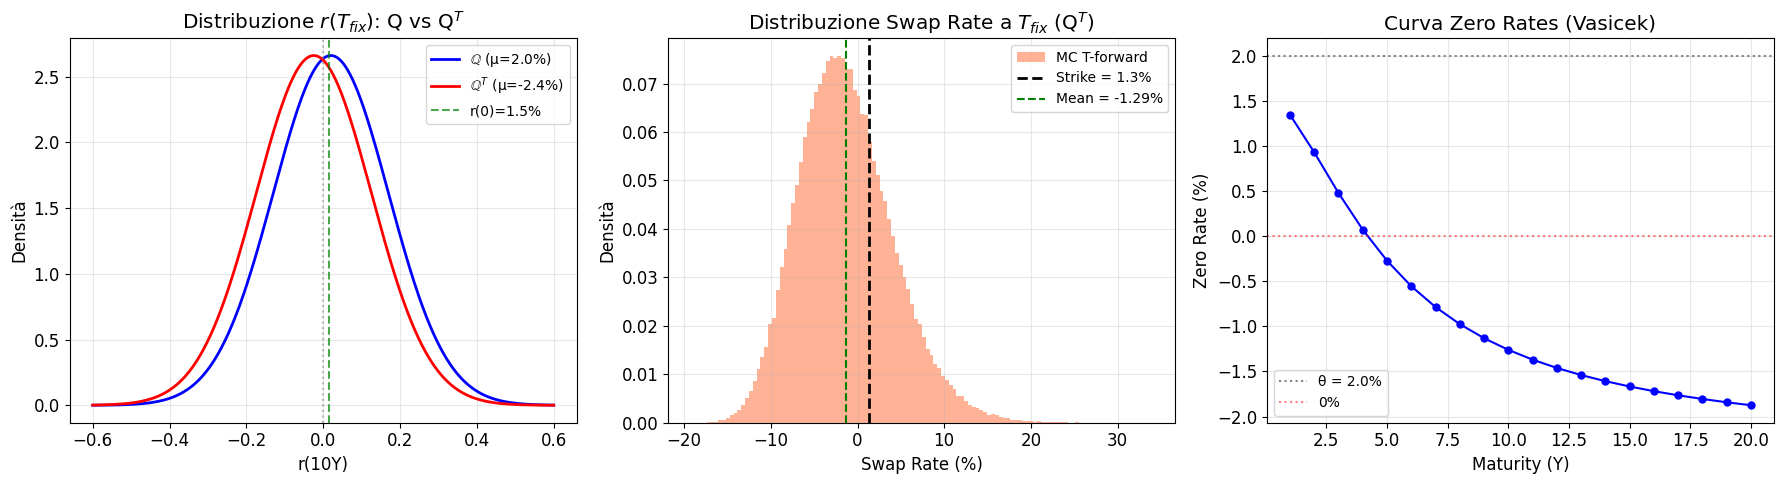

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Distribuzione di r(T_fix) sotto Q e Q^T ---
x_plot = np.linspace(-0.6, 0.6, 500)
axes[0].plot(x_plot, norm.pdf(x_plot, mu_Q, v), 'b-', lw=2, label=f'$\\mathbb{{Q}}$ (μ={mu_Q*100:.1f}%)')
axes[0].plot(x_plot, norm.pdf(x_plot, mu_QT, v), 'r-', lw=2, label=f'$\\mathbb{{Q}}^T$ (μ={mu_QT*100:.1f}%)')
axes[0].axvline(r0, color='green', ls='--', alpha=0.7, label=f'r(0)={r0*100}%')
axes[0].axvline(0, color='gray', ls=':', alpha=0.5)
axes[0].set_xlabel('r(10Y)')
axes[0].set_ylabel('Densità')
axes[0].set_title('Distribuzione $r(T_{fix})$: Q vs Q$^T$')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# --- 2. Distribuzione swap rate sotto Q^T ---
axes[1].hist(S_fwd*100, bins=120, density=True, alpha=0.6, color='coral', label='MC T-forward')
axes[1].axvline(strike*100, color='black', ls='--', lw=2, label=f'Strike = {strike*100}%')
axes[1].axvline(np.mean(S_fwd)*100, color='green', ls='--', lw=1.5, label=f'Mean = {np.mean(S_fwd)*100:.2f}%')
axes[1].set_xlabel('Swap Rate (%)')
axes[1].set_ylabel('Densità')
axes[1].set_title('Distribuzione Swap Rate a $T_{fix}$ (Q$^T$)')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# --- 3. Curva zero rates ---
axes[2].plot(maturities, zero_rates*100, 'bo-', markersize=5)
axes[2].axhline(theta*100, color='gray', ls=':', label=f'θ = {theta*100}%')
axes[2].axhline(0, color='red', ls=':', alpha=0.5, label='0%')
axes[2].set_xlabel('Maturity (Y)')
axes[2].set_ylabel('Zero Rate (%)')
axes[2].set_title('Curva Zero Rates (Vasicek)')
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

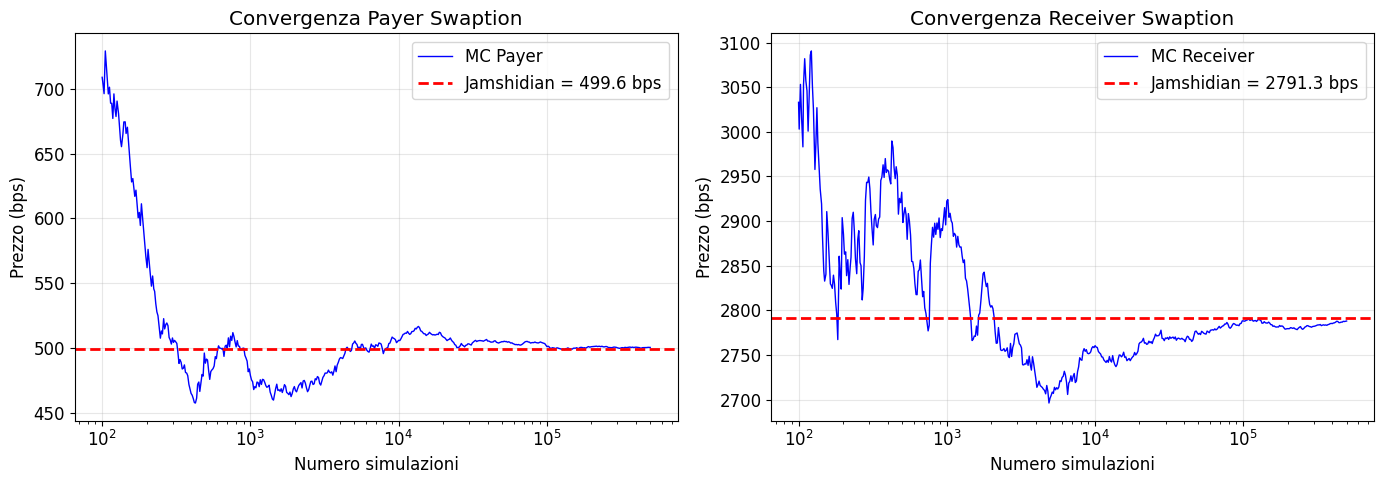

In [13]:
# --- Convergenza MC ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Running mean del prezzo
cumsum_payer = np.cumsum(payer_pf_conv)
cumsum_receiver = np.cumsum(receiver_pf_conv)
ns = np.arange(1, N_max + 1)
running_payer = P_0_Tfix * cumsum_payer / ns * 10000
running_receiver = P_0_Tfix * cumsum_receiver / ns * 10000

# Sottocamp. per plotting
idx = np.unique(np.geomspace(100, N_max, 500).astype(int))

axes[0].plot(idx, running_payer[idx-1], 'b-', lw=1, label='MC Payer')
axes[0].axhline(payer_J*10000, color='red', ls='--', lw=2, label=f'Jamshidian = {payer_J*10000:.1f} bps')
axes[0].set_xscale('log')
axes[0].set_xlabel('Numero simulazioni')
axes[0].set_ylabel('Prezzo (bps)')
axes[0].set_title('Convergenza Payer Swaption')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(idx, running_receiver[idx-1], 'b-', lw=1, label='MC Receiver')
axes[1].axhline(receiver_J*10000, color='red', ls='--', lw=2, label=f'Jamshidian = {receiver_J*10000:.1f} bps')
axes[1].set_xscale('log')
axes[1].set_xlabel('Numero simulazioni')
axes[1].set_ylabel('Prezzo (bps)')
axes[1].set_title('Convergenza Receiver Swaption')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

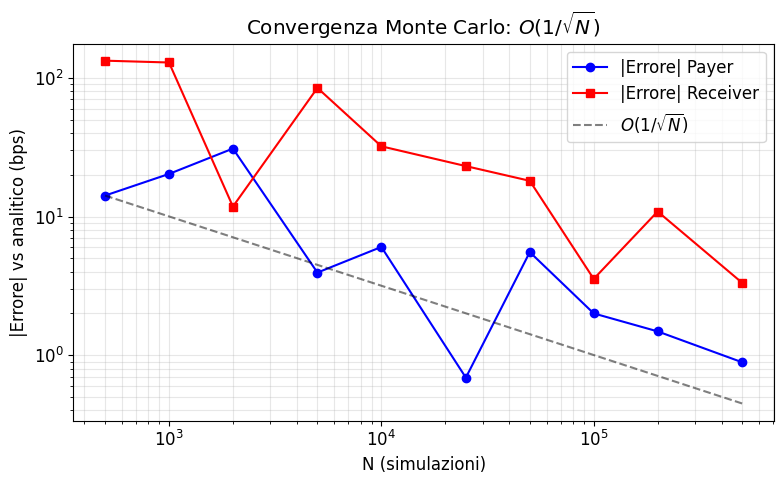

In [14]:
# --- Errore MC vs 1/sqrt(N) ---
fig, ax = plt.subplots(figsize=(8, 5))

n_plot = np.array([500, 1000, 2000, 5000, 10000, 25000, 50000, 100000, 200000, 500000])
errs_payer = [abs(P_0_Tfix * np.mean(payer_pf_conv[:n]) - payer_J)*10000 for n in n_plot]
errs_receiver = [abs(P_0_Tfix * np.mean(receiver_pf_conv[:n]) - receiver_J)*10000 for n in n_plot]

ax.loglog(n_plot, errs_payer, 'bo-', label='|Errore| Payer')
ax.loglog(n_plot, errs_receiver, 'rs-', label='|Errore| Receiver')

# Riferimento 1/sqrt(N)
c_ref = errs_payer[0] * np.sqrt(n_plot[0])
ax.loglog(n_plot, c_ref / np.sqrt(n_plot), 'k--', alpha=0.5, label=r'$O(1/\sqrt{N})$')

ax.set_xlabel('N (simulazioni)')
ax.set_ylabel('|Errore| vs analitico (bps)')
ax.set_title('Convergenza Monte Carlo: $O(1/\\sqrt{N})$')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Tabella Riassuntiva

In [15]:
print("=" * 65)
print("  RISULTATI FINALI — GRUPPO 7")
print("=" * 65)
print(f"  Modello:   Vasicek (r0={r0}, k={k}, θ={theta}, σ={sigma})")
print(f"  Swaption:  fixing={T_fix:.0f}Y, tenor={tenor:.0f}Y, strike={strike*100}%")
print(f"  MC:        {N_sim:,} simulazioni")
print(f"-" * 65)
print(f"{'Metodo':<35} {'Payer':>10} {'Receiver':>10} {'Unità':>8}")
print(f"-" * 65)
print(f"{'Jamshidian (analitico)':<35} {payer_J*10000:>10.2f} {receiver_J*10000:>10.2f} {'bps':>8}")
print(f"{'MC Risk-Neutral Q':<35} {payer_Q*10000:>10.2f} {receiver_Q*10000:>10.2f} {'bps':>8}")
print(f"{'MC T-forward':<35} {payer_fwd*10000:>10.2f} {receiver_fwd*10000:>10.2f} {'bps':>8}")
print(f"-" * 65)
print(f"{'Jamshidian (analitico)':<35} {payer_J:>10.6f} {receiver_J:>10.6f} {'price':>8}")
print(f"{'MC Risk-Neutral Q':<35} {payer_Q:>10.6f} {receiver_Q:>10.6f} {'price':>8}")
print(f"{'MC T-forward':<35} {payer_fwd:>10.6f} {receiver_fwd:>10.6f} {'price':>8}")
print(f"=" * 65)

  RISULTATI FINALI — GRUPPO 7
  Modello:   Vasicek (r0=0.015, k=0.5, θ=0.02, σ=0.15)
  Swaption:  fixing=10Y, tenor=5Y, strike=1.3%
  MC:        200,000 simulazioni
-----------------------------------------------------------------
Metodo                                   Payer   Receiver    Unità
-----------------------------------------------------------------
Jamshidian (analitico)                  499.64    2791.31      bps
MC Risk-Neutral Q                       496.85    2801.18      bps
MC T-forward                            500.69    2788.80      bps
-----------------------------------------------------------------
Jamshidian (analitico)                0.049964   0.279131    price
MC Risk-Neutral Q                     0.049685   0.280118    price
MC T-forward                          0.050069   0.278880    price


---
## 11. Commenti e Osservazioni

### Scelta della misura

Abbiamo implementato **entrambe le misure** e verificato che convergono allo stesso risultato:

1. **Misura risk-neutral $\mathbb{Q}$** (multi-step): simuliamo l'intero path di $r(t)$ da 0 a $T_{fix}$ usando la distribuzione esatta dell'OU, e accumuliamo lo sconto stocastico $D(0,T) = e^{-\int r\,ds}$. Il prezzo è $\mathbb{E}^{\mathbb{Q}}[D \cdot \text{Payoff}]$.

2. **Misura $T$-forward** (single-step): simuliamo $r(T_{fix})$ in un solo step sotto la distribuzione $\mathbb{Q}^T$ (media più bassa di $\sim 4.4\%$ rispetto a $\mathbb{Q}$), e scontiamo con il fattore deterministico $P(0, T_{fix})$.

**Punto chiave:** non si possono mescolare le misure (simulare sotto $\mathbb{Q}$ e scontare con $P(0,T)$ deterministico) perché il fattore di sconto stocastico è correlato con il payoff. Questo errore produce deviazioni significative ($\sim$ centinaia di bps).

### Osservazioni sui risultati

1. La **receiver swaption** vale molto più della payer ($\sim 2791$ vs $\sim 500$ bps): lo swap rate forward medio è inferiore allo strike, quindi la receiver è deep ITM.

2. La **curva zero rates** diventa negativa per maturità lunghe, conseguenza di $\sigma = 0.15$ elevato. Questo è un limite noto del modello Vasicek (che ammette tassi negativi senza bound).

3. $P(0, 10Y) > 1$: il prezzo dello ZCB a 10 anni supera il par, coerente con tassi medi negativi.

4. La **put-call parity** $\text{Payer} - \text{Receiver} = V_{\text{swap}}$ è verificata in tutti e tre i metodi.

5. La **convergenza MC** segue $O(1/\sqrt{N})$. Con 200,000 simulazioni l'errore standard è $\sim 3\text{-}6$ bps (IC 95%).

6. La **formula di Jamshidian** conferma perfettamente i risultati MC, validando l'implementazione.

### Confronto MC multi-step vs single-step

| Aspetto | MC $\mathbb{Q}$ (multi-step) | MC $\mathbb{Q}^T$ (single-step) |
|---------|------------------------------|----------------------------------|
| Simulazione | Path completo ($N_{steps}$ step) | Un solo punto $r(T_{fix})$ |
| Sconto | Stocastico $D(0,T)$ | Deterministico $P(0,T)$ |
| Costo computaz. | $O(N_{sim} \times N_{steps})$ | $O(N_{sim})$ |
| Bias | Nessuno (simulaz. esatta OU) | Nessuno (distribuz. esatta) |
| Varianza | Più alta (rumore da $D$) | Più bassa (sconto deterministico) |
| Estendibilità | Payoff path-dependent | Solo payoff a $T_{fix}$ |